# Import Libraries

In [1]:
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 

from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from scipy.stats import kendalltau, spearmanr
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
import pickle
import json

# Import Bigquery

In [2]:
from google.oauth2 import service_account
from google.cloud import bigquery

# Authenticate using a service account key file
credentials = service_account.Credentials.from_service_account_file(
    'quixotic-booth-413509-c86c14cca6c7.json',
    scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

# Specify your project ID
project_id_akun = "quixotic-booth-413509"

# Create a BigQuery client object using the credentials and project ID
client = bigquery.Client(credentials=credentials, project=project_id_akun)

# Your query to fetch data from BigQuery
query = '''
SELECT * FROM `quixotic-booth-413509.destination.churn_clean`
'''

# Execute the query and convert the results to a pandas DataFrame
df = client.query(query).to_dataframe()

# Data Loading

In [3]:
df.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,active_member,estimated_salary,exited
0,594,Spain,Female,24,0,97378.54,1,1,1,71405.17,0
1,636,Spain,Female,33,0,0.00,1,1,0,92277.47,1
2,573,Spain,Male,33,1,160777.90,1,1,1,149536.15,0
3,619,Spain,Female,38,1,0.00,1,1,0,112442.63,1
4,776,Spain,Male,39,2,104349.45,1,0,0,79503.05,0


In [4]:
df.tail()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,active_member,estimated_salary,exited
9995,630,Germany,Male,50,3,129370.91,4,1,1,47775.34,1
9996,819,Germany,Female,49,1,120656.86,4,0,0,166164.30,1
9997,738,Germany,Male,58,2,133745.44,4,1,0,28373.86,1
9998,665,Germany,Female,43,2,116322.27,4,1,0,35640.12,1
9999,847,Germany,Female,41,3,101543.51,4,1,0,16025.17,1


In [5]:
# Use pd.cut for "has_credit_card" column since values are not continuous
df["has_credit_card"] = pd.cut(df["has_credit_card"], bins=2, labels=['no', 'yes']).astype(str)
# Use pd.cut for "active_member" column since values are not continuous
df["active_member"] = pd.cut(df["active_member"], bins=2, labels=['no', 'yes']).astype(str)

In [6]:
# Cek apakah target balance atau tidak
df['exited'].value_counts()

exited
0    7963
1    2037
Name: count, dtype: Int64

In [7]:
ros = RandomOverSampler(sampling_strategy=1)
x = df.drop(['exited'], axis=1)
y = df[['exited']]
x, y = ros.fit_resample(x, y) 
df = pd.concat([x, y], axis=1)

In [8]:
df.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,active_member,estimated_salary,exited
0,594,Spain,Female,24,0,97378.54,1,yes,yes,71405.17,0
1,636,Spain,Female,33,0,0.00,1,yes,no,92277.47,1
2,573,Spain,Male,33,1,160777.90,1,yes,yes,149536.15,0
3,619,Spain,Female,38,1,0.00,1,yes,no,112442.63,1
4,776,Spain,Male,39,2,104349.45,1,no,no,79503.05,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15926 entries, 0 to 15925
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      15926 non-null  Int64  
 1   geography         15926 non-null  object 
 2   gender            15926 non-null  object 
 3   age               15926 non-null  Int64  
 4   tenure            15926 non-null  Int64  
 5   balance           15926 non-null  float64
 6   num_of_products   15926 non-null  Int64  
 7   has_credit_card   15926 non-null  object 
 8   active_member     15926 non-null  object 
 9   estimated_salary  15926 non-null  float64
 10  exited            15926 non-null  Int64  
dtypes: Int64(5), float64(2), object(4)
memory usage: 1.4+ MB


In [10]:
# cek missing value
df.isnull().sum()

credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_credit_card     0
active_member       0
estimated_salary    0
exited              0
dtype: int64

# EDA

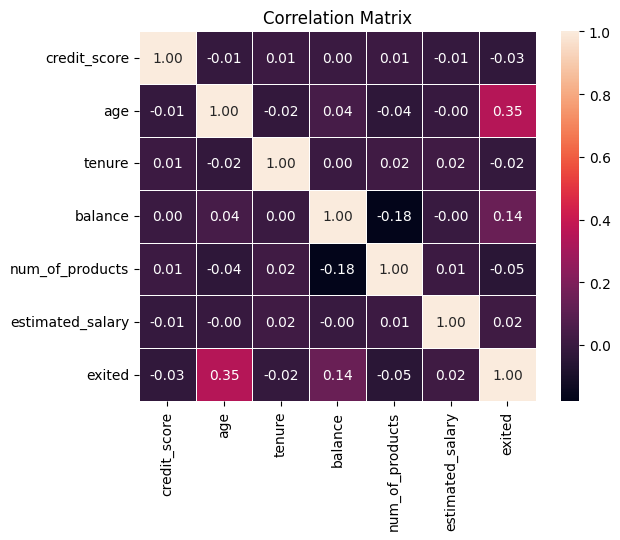

In [11]:
# list kolom yang akan diuji korelasinya
cols = ['credit_score', 'age', 'tenure', 'balance',
       'num_of_products', 'estimated_salary',
       'exited' ]
# plot korelasi setiap variable menggunakan heatmap
sns.heatmap(df[cols].corr(), annot = True, fmt=".2f", linewidths=0.5)
# Memberikan judul
plt.title('Correlation Matrix')
# menampilkan correlation matrix
plt.show()

# Feature Engineering

In [12]:
cat_columns = ['geography', 'gender', 'has_credit_card', 'active_member']
num_columns = ['credit_score', 'age', 'tenure', 'balance','num_of_products', 'estimated_salary']

## Handling Cardinality

In [13]:
# mendefinisikan kolom yang masuk ke tipe data kategorik dan dijadikan sebagai list
cat_cols = cat_columns

# membuat list kosong listItem
listItem = []
# membuat forloop untuk kolom yang berada di dalam cat_cols
for col in cat_cols:
  # memasukkan nama kolom dan jumlah nilai unique pada list
  listItem.append([col, df[col].nunique(), df[col].unique()])

# membuat dataframe dari listItem
pd.DataFrame(columns=['Nama Kolom', 'Jumlah Nilai Unique', 'Nilai Unique'], data=listItem)

,Nama Kolom,Jumlah Nilai Unique,Nilai Unique
0,geography,3,"[Spain, France, Germany]"
1,gender,2,"[Female, Male]"
2,has_credit_card,2,"[yes, no]"
3,active_member,2,"[yes, no]"


## Cek Target

In [14]:
# Cek apakah target balance atau tidak
df['exited'].value_counts()

exited
0    7963
1    7963
Name: count, dtype: Int64

## Splitting Feature X dan y

In [15]:
#memisahkan antara fitur x dan y
X = df.drop(['exited'], axis = 1)
y = df['exited']

In [16]:
# split data menjadi empat bagian, X_train, X_test, y_train, dan y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, # komposisi data test sebesar 20% dari keseluruhan data
                                                    stratify=y,
                                                    random_state = 42)     # State kerandoman data ada pada state ke 0

# Menampilkan ukuran dataframe dari X_train, X_test, y_train, dan y_test
print('X Train Size: ', X_train.shape)
print('X Test Size: ', X_test.shape)
print('y Train Size: ', y_train.shape)
print('y Test Size: ', y_test.shape)

X Train Size:  (12740, 10)
X Test Size:  (3186, 10)
y Train Size:  (12740,)
y Test Size:  (3186,)


## Handling Outliers

In [17]:
# Mendefinisikan kolom numerik 
num_cols = X_train[num_columns]
# Membuat list kosong 
listItem= []
# Membuat forloop untuk kolom di dalam num_cols
for col in num_cols:
  # Memasukkan kolom yang merupakan kolom numerik dan menghitung nilai skew nya
  listItem.append([col, X_train[col].skew()])

# membuat dataframe dari nilai skew yang telah dihitung
pd.DataFrame(columns=['Nama Kolom', 'Nilai Skewness'], data= listItem)

,Nama Kolom,Nilai Skewness
0,credit_score,-0.094879
1,age,0.611266
2,tenure,0.028724
3,balance,-0.265955
4,num_of_products,1.283780
5,estimated_salary,-0.009996


In [18]:
# capping data untuk data yang mengalami skewed
winsoriser2 = Winsorizer(capping_method='iqr', # menggunakan metode IQR
                            tail='both', # capping dilakukan pada outlier batas atas dan batas bawah
                            fold=3, # menetapkan nilai fold
                            #mendefinisikan kolom yang data nya terdistribusi secara skewed
                            variables=[ 'age', 'num_of_products'],
                            missing_values='ignore')

# mendefinisikan dataset X_train yang telah di capping  dengan melakukan fit_transform
X_train = winsoriser2.fit_transform(X_train)
# mendefinisikan dataset X_test yang telah di capping  dengan melakukan transform
X_test = winsoriser2.transform(X_test)

In [19]:
variables = ['credit_score', 'tenure', 'balance', 'estimated_salary']
# Convert the dtype of the variables to float64
X_train[variables] = X_train[variables].astype(np.float64)
X_test[variables] = X_test[variables].astype(np.float64)

# Capping data untuk data terdistribusi normal
winsoriser1 = Winsorizer(capping_method='gaussian', # Metode capping yang digunakan adalah gaussian untuk data terdistribusi normal
                            tail='both', # capping dilakukan pada outlier batas atas dan batas bawah
                            fold=1.5,
                            # mendefinisikan kolom yang data nya terdistribusi secara normal
                            variables= variables,
                            # ignore missing value
                            missing_values='ignore')

# mendefinisikan dataset X_train yang telah di capping  dengan melakukan fit_transform
X_train = winsoriser1.fit_transform(X_train)
# mendefinisikan dataset X_test yang telah di capping  dengan melakukan transform
X_test = winsoriser1.transform(X_test)

## Handling Missing Value

In [20]:
X_train.isnull().sum()

credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_credit_card     0
active_member       0
estimated_salary    0
dtype: int64

In [21]:
X_test.isnull().sum()

credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_credit_card     0
active_member       0
estimated_salary    0
dtype: int64

In [22]:
y_train.isnull().sum()

0

In [23]:
y_test.isnull().sum()

0

## Feature Selection

In [24]:
X_train.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,active_member,estimated_salary
931,712.000000,Spain,Male,47,1.0,139887.01,1,yes,yes,95719.73
3388,722.000000,France,Female,49,3.0,168197.66,1,yes,no,140765.57
3548,678.000000,France,Male,43,5.0,102338.19,1,yes,yes,79649.62
6058,730.000000,France,Male,34,1.0,0.00,2,yes,yes,126592.01
14282,502.340891,France,Female,39,9.0,117103.26,2,yes,yes,85937.52


In [25]:
# menampilkan list kolom numerik dan kolom kategorik
print('Numeric Columns: ', num_columns)
print('Categorical Columns: ', cat_columns)

Numeric Columns:  ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
Categorical Columns:  ['geography', 'gender', 'has_credit_card', 'active_member']


In [26]:
# Split kolom numerik dan kolom kategorik pada dataset train dan test
X_train_num = X_train[num_columns]
X_train_cat = X_train[cat_columns]

X_test_num = X_test[num_columns]
X_test_cat = X_test[cat_columns]

# menampilkan dataset train numerik
print('X_train_num:', X_train_num.shape)
print('X_test_num:', X_test_num.shape)
print('')
print('X_train_cat:', X_train_cat.shape)
print('X_test_cat:', X_test_cat.shape)

X_train_num: (12740, 6)
X_test_num: (3186, 6)

X_train_cat: (12740, 4)
X_test_cat: (3186, 4)


## Uji Korelasi

In [27]:
# Mendefinisikan list kosong untuk p_values, interpretasi, dan cols
p_values = []
interpretasi = []
cols = []

# melakukan forloop untuk kolom yang terdapat didalam dataset kategorik
for col in X_train_cat.columns:
  # melakukan uji korelasi dengan menggunakan kendaltau pada setiap kolom dataset kategorik
  corr_coef, p_value = kendalltau(X_train_cat[col], y_train)

  #input p_values ke dalam list p_values
  p_values.append(p_value)
  # input nama kolom ke list cols
  cols.append(col)

  # dilakukan pengecekan, jika p_value di bawah nilai 0.05, maka terdapat korelasi
  if p_value < 0.05:
    interpretasi.append('Terdapat Korelasi')
  # jika p_value berada di atas nilai 0.05, maka tidak terdapat korelasi
  else :
    interpretasi.append('Tidak terdapat korelasi')

# membuat dataframe untuk nama kolom dan hasil dari interpretasi
pd.DataFrame({'nama kolom':cols,
              'hasil': interpretasi})

,nama kolom,hasil
0,geography,Terdapat Korelasi
1,gender,Terdapat Korelasi
2,has_credit_card,Tidak terdapat korelasi
3,active_member,Terdapat Korelasi


In [28]:
# Drop kolom yang tidak memiliki korelasi pada dataset train dan test
X_train_cat = X_train_cat.copy()  
X_test_cat = X_test_cat.copy()
X_train_cat.drop(['has_credit_card'], axis=1, inplace=True)
X_test_cat.drop(['has_credit_card'], axis=1, inplace=True)

In [29]:
# Mendefinisikan list kosong untuk p_values, interpretasi, dan cols
p_values = []
interpretasi = []
cols = []

# forloop untuk kolom yang berada di dataset numerik
for col in X_train_num.columns:
  # melakukan perhitungan uji korelasi dengan menggunakan pearsonr untuk data numerik
  corr_coef, p_value = spearmanr(X_train_num[col], y_train)

  # p_value yang didapat kemudian dimasukkan ke dalam list p_value
  p_values.append(p_value)
  # memasukkan nama dari setiap kolom numerik
  cols.append(col)

  # cek jika p_value di bawah 0.05, maka terdapat korelasi
  if p_value < 0.05:
    interpretasi.append('Terdapat korelasi')
  # jika p_value di atas nilai 0.05, maka tidak terdapat korelasi
  else :
    interpretasi.append('Tidak terdapat korelasi')

# membuat dataframe untuk kolom han hasil interpretasi
pd.DataFrame({'nama kolom':cols,
              'hasil': interpretasi})

,nama kolom,hasil
0,credit_score,Terdapat korelasi
1,age,Terdapat korelasi
2,tenure,Tidak terdapat korelasi
3,balance,Terdapat korelasi
4,num_of_products,Terdapat korelasi
5,estimated_salary,Terdapat korelasi


In [30]:
# copy dataset train dan test dari data numerik
X_train_num = X_train_num.copy()
X_test_num= X_test_num.copy()

# remove kolom yang tidak berkorelasi di X_train_num dan X_test_num
X_train_num.drop(['tenure'], axis=1, inplace=True)
X_test_num.drop(['tenure'], axis=1, inplace=True)

## Concate kolom numerik dan kategorik

In [31]:
#Concate kolom train dan test
X_train = np.concatenate([X_train_num, X_train_cat], axis = 1)
X_test = np.concatenate([X_test_num, X_test_cat], axis = 1)

# menunjukkan dataset array final yang telah di concate
X_train

array([[712.0, 47, 139887.01, ..., 'Spain', 'Male', 'yes'],
       [722.0, 49, 168197.66, ..., 'France', 'Female', 'no'],
       [678.0, 43, 102338.19, ..., 'France', 'Male', 'yes'],
       ...,
       [533.0, 39, 0.0, ..., 'France', 'Female', 'yes'],
       [753.0, 40, 3768.69, ..., 'France', 'Female', 'no'],
       [745.0, 21, 137910.45, ..., 'France', 'Male', 'yes']], dtype=object)

In [32]:
# Cek dimensi dataset final
X_train.shape

(12740, 8)

In [33]:
# Membuat dataframe untuk X_train
X_train = pd.DataFrame(X_train, columns=np.concatenate([X_train_num.columns, X_train_cat.columns]))
# Menampilkan dataframe X_train
X_train.head(3)

,credit_score,age,balance,num_of_products,estimated_salary,geography,gender,active_member
0,712.0,47,139887.01,1,95719.73,Spain,Male,yes
1,722.0,49,168197.66,1,140765.57,France,Female,no
2,678.0,43,102338.19,1,79649.62,France,Male,yes


In [34]:
# Membuat dataframe untuk X_test
X_test = pd.DataFrame(X_test, columns=np.concatenate([X_test_num.columns, X_test_cat.columns]))
# Menampilkan dataframe X_test
X_test.head(3)

,credit_score,age,balance,num_of_products,estimated_salary,geography,gender,active_member
0,643.0,34,117451.47,1,65374.86,Spain,Female,no
1,600.0,37,0.0,3,13547.736588,France,Female,no
2,701.0,42,0.0,2,24210.56,Spain,Female,no


# Modelling

In [35]:
num_columns = X_train_num.columns.to_list()
cat_columns= X_train_cat.columns.to_list()

# Membuat kolom tranformer untuk preprocessing
transformer = ColumnTransformer([
    ('scaler', MinMaxScaler(), num_columns),
    ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_columns)       
])

#Membuat pipeline untuk Logreg
model_logreg = Pipeline([
('transformer', transformer),
('classifier', LogisticRegression())
])

#Membuat pipeline untuk SVM
model_svm = Pipeline([
('transformer', transformer),
('classifier', SVC())
])

#Membuat pipeline untuk KNN
model_knn = Pipeline([
('transformer', transformer),
('classifier', KNeighborsClassifier())
])

#Membuat pipeline untuk Decision Tree
model_dt = Pipeline([
('transformer', transformer),
('classifier', DecisionTreeClassifier())
])

#Membuat pipeline untuk Random Forest   
model_rf = Pipeline([
('transformer', transformer),
('classifier', RandomForestClassifier())
])

#Membuat pipeline untuk XGBoost
model_xgb = Pipeline([
('transformer', transformer),
('classifier', XGBClassifier())
])

## Logistic Regression

In [36]:
# fit model pada train set
model_logreg.fit(X_train, y_train)
# predict model pada test set
y_logreg_pred = model_logreg.predict(X_test)
# Menampilkan nilai akurasi training dan testing
print('Training Score: ',round(model_logreg.score(X_train, y_train),4))
print('Testing Score: ', round(model_logreg.score(X_test, y_test),4))

Training Score:  0.7024
Testing Score:  0.7125


In [37]:
# Mendefinisikan target
target = ['No', 'Yes']
# menampilkan classification report
print(classification_report(y_test, y_logreg_pred, target_names=target))

              precision    recall  f1-score   support

          No       0.71      0.71      0.71      1593
         Yes       0.71      0.71      0.71      1593

    accuracy                           0.71      3186
   macro avg       0.71      0.71      0.71      3186
weighted avg       0.71      0.71      0.71      3186



In [38]:
# menggunakan StratifiedKFold untuk cross-validation
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# mendefinisikan F1 scorer untuk cross validation
f1_scorer = make_scorer(f1_score)

# menghitung cross validation
f1_train_cross_val = cross_val_score(model_logreg, X_train, y_train, cv=stratified_kfold, scoring=f1_scorer)

# menampilkan hasil
print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean() - f1_train_cross_val.std()), '-', (f1_train_cross_val.mean() + f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.70574163 0.69069212 0.69689058]
F1 Score - Mean - Cross Validation :  0.6977747758951361
F1 Score - Std - Cross Validation  :  0.006175664004605689
F1 Score - Range of Test-Set       :  0.6915991118905305 - 0.7039504398997418


## Support Vector Machine (SVM)

In [39]:
# fit model pada train set
model_svm.fit(X_train, y_train)
# predict model pada test set
y_svm_pred = model_svm.predict(X_test)
# Menampilkan nilai akurasi training dan testing
print('Training Score: ',round(model_svm.score(X_train, y_train),4))
print('Testing Score: ', round(model_svm.score(X_test, y_test),4))

Training Score:  0.7686
Testing Score:  0.7724


In [40]:
# Mendefinisikan target
target = ['No', 'Yes']
# menampilkan classification report
print(classification_report(y_test, y_svm_pred, target_names=target))

              precision    recall  f1-score   support

          No       0.75      0.82      0.78      1593
         Yes       0.80      0.73      0.76      1593

    accuracy                           0.77      3186
   macro avg       0.77      0.77      0.77      3186
weighted avg       0.77      0.77      0.77      3186



In [42]:
# menggunakan StratifiedKFold untuk cross-validation
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# mendefinisikan F1 scorer untuk cross validation
f1_scorer = make_scorer(f1_score)

# menghitung cross validation
f1_train_cross_val = cross_val_score(model_svm, X_train, y_train, cv=stratified_kfold, scoring=f1_scorer)

# menampilkan hasil
print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean() - f1_train_cross_val.std()), '-', (f1_train_cross_val.mean() + f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.74876115 0.74871795 0.73800738]
F1 Score - Mean - Cross Validation :  0.7451621594816237
F1 Score - Std - Cross Validation  :  0.005059223778483371
F1 Score - Range of Test-Set       :  0.7401029357031403 - 0.750221383260107


## KNN

In [43]:
# fit model pada train set
model_knn.fit(X_train, y_train)
# predict model pada test set
y_knn_pred = model_knn.predict(X_test)
# Menampilkan nilai akurasi training dan testing
print('Training Score: ',round(model_knn.score(X_train, y_train),4))
print('Testing Score: ', round(model_knn.score(X_test, y_test),4))

Training Score:  0.8847
Testing Score:  0.8104


In [44]:
# menampilkan classification report
print(classification_report(y_test, y_knn_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.73      0.79      1593
         1.0       0.77      0.89      0.82      1593

    accuracy                           0.81      3186
   macro avg       0.82      0.81      0.81      3186
weighted avg       0.82      0.81      0.81      3186



In [45]:
# menggunakan StratifiedKFold untuk cross-validation
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# mendefinisikan F1 scorer untuk cross validation
f1_scorer = make_scorer(f1_score)

# menghitung cross validation
f1_train_cross_val = cross_val_score(model_knn, X_train, y_train, cv=stratified_kfold, scoring=f1_scorer)

# menampilkan hasil
print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean() - f1_train_cross_val.std()), '-', (f1_train_cross_val.mean() + f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.79891916 0.80763116 0.78641644]
F1 Score - Mean - Cross Validation :  0.7976555887253544
F1 Score - Std - Cross Validation  :  0.008706837216275964
F1 Score - Range of Test-Set       :  0.7889487515090784 - 0.8063624259416303


## Random Forest

In [46]:
# fit model pada train set
model_rf.fit(X_train, y_train)
# predict model pada test set
y_rf_pred = model_rf.predict(X_test)
# Menampilkan nilai akurasi training dan testing
print('Training Score: ',round(model_rf.score(X_train, y_train),4))
print('Testing Score: ', round(model_rf.score(X_test, y_test),4))

Training Score:  1.0
Testing Score:  0.9463


In [47]:
# menampilkan classification report
print(classification_report(y_test, y_rf_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94      1593
         1.0       0.92      0.98      0.95      1593

    accuracy                           0.95      3186
   macro avg       0.95      0.95      0.95      3186
weighted avg       0.95      0.95      0.95      3186



In [48]:
# menggunakan StratifiedKFold untuk cross-validation
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# mendefinisikan F1 scorer untuk cross validation
f1_scorer = make_scorer(f1_score)

# menghitung cross validation
f1_train_cross_val = cross_val_score(model_rf, X_train, y_train, cv=stratified_kfold, scoring=f1_scorer)

# menampilkan hasil
print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean() - f1_train_cross_val.std()), '-', (f1_train_cross_val.mean() + f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.91780822 0.92457531 0.91989076]
F1 Score - Mean - Cross Validation :  0.9207580969146024
F1 Score - Std - Cross Validation  :  0.002829910392134723
F1 Score - Range of Test-Set       :  0.9179281865224677 - 0.9235880073067372


## Decision Tree

In [49]:
# fit model pada train set
model_dt.fit(X_train, y_train)
# predict model pada test set
y_dt_pred = model_dt.predict(X_test)
# Menampilkan nilai akurasi training dan testing
print('Training Score: ',round(model_dt.score(X_train, y_train),4))
print('Testing Score: ', round(model_dt.score(X_test, y_test),4))

Training Score:  1.0
Testing Score:  0.9127


In [50]:
# menampilkan classification report
print(classification_report(y_test, y_dt_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.85      0.91      1593
         1.0       0.87      0.98      0.92      1593

    accuracy                           0.91      3186
   macro avg       0.92      0.91      0.91      3186
weighted avg       0.92      0.91      0.91      3186



In [51]:
# menggunakan StratifiedKFold untuk cross-validation
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# mendefinisikan F1 scorer untuk cross validation
f1_scorer = make_scorer(f1_score)

# menghitung cross validation
f1_train_cross_val = cross_val_score(model_dt, X_train, y_train, cv=stratified_kfold, scoring=f1_scorer)

# menampilkan hasil
print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean() - f1_train_cross_val.std()), '-', (f1_train_cross_val.mean() + f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.89242324 0.90233172 0.88913476]
F1 Score - Mean - Cross Validation :  0.8946299076232199
F1 Score - Std - Cross Validation  :  0.005609037528583276
F1 Score - Range of Test-Set       :  0.8890208700946366 - 0.9002389451518032


## XGBoost

In [52]:
# fit model pada train set
model_xgb.fit(X_train, y_train)
# predict model pada test set
y_xgb_pred = model_xgb.predict(X_test)
# Menampilkan nilai akurasi training dan testing
print('Training Score: ',round(model_xgb.score(X_train, y_train),4))
print('Testing Score: ', round(model_xgb.score(X_test, y_test),4))

Training Score:  0.9622
Testing Score:  0.9052


In [53]:
# menampilkan classification report
print(classification_report(y_test, y_xgb_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.87      0.90      1593
         1.0       0.88      0.94      0.91      1593

    accuracy                           0.91      3186
   macro avg       0.91      0.91      0.91      3186
weighted avg       0.91      0.91      0.91      3186



In [54]:
# menggunakan StratifiedKFold untuk cross-validation
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# mendefinisikan F1 scorer untuk cross validation
f1_scorer = make_scorer(f1_score)

# menghitung cross validation
f1_train_cross_val = cross_val_score(model_xgb, X_train, y_train, cv=stratified_kfold, scoring=f1_scorer)

# menampilkan hasil
print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean() - f1_train_cross_val.std()), '-', (f1_train_cross_val.mean() + f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.88666818 0.87577213 0.88700435]
F1 Score - Mean - Cross Validation :  0.8831482233701874
F1 Score - Std - Cross Validation  :  0.005217487789701657
F1 Score - Range of Test-Set       :  0.8779307355804857 - 0.888365711159889


# Model Optimization

In [55]:
param_logreg = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

param_knn = {
    'classifier__n_neighbors': np.arange(2, 30, 1), 
    'classifier__weights': ['uniform', 'distance'], 
}
param_dt = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [5, 10, 15, 20],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__ccp_alpha': [0.0, 0.1, 0.2],
}

param_rf = {
    'classifier__n_estimators': np.arange(200, 401, 30),
    'classifier__max_depth': np.arange(4, 8, 2), 
    'classifier__min_samples_split': [2, 5, 10],
}

param_svm = {
    'classifier__C': [0.1, 1, 10, 100],  
    'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001]  
}

param_xgb = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__n_estimators': [50, 100, 150],
    'classifier__learning_rate': [0.1, 0.01, 0.001],
    'transformer__verbose': [0],
}

## GridSearchCV (All Models)

In [57]:
# proses grid search untuk tuning hyperparameter secara paralel (Logistic Regression)
grid_logreg = GridSearchCV(model_logreg, param_grid=param_logreg, cv=stratified_kfold, n_jobs=-1).fit(X_train, y_train)

In [58]:
# proses grid search untuk tuning hyperparameter secara paralel (KNN)
grid_knn = GridSearchCV(model_knn, param_grid=param_knn, cv=stratified_kfold, n_jobs=-1).fit(X_train, y_train)

In [59]:
# proses grid search untuk tuning hyperparameter secara paralel (Random Forest)
grid_rf = GridSearchCV(model_rf, param_grid=param_rf, cv=stratified_kfold, n_jobs=-1).fit(X_train, y_train)

In [60]:
# proses grid search untuk tuning hyperparameter secara paralel (Decision Tree)
grid_dt = GridSearchCV(model_dt, param_grid=param_dt, cv=stratified_kfold, n_jobs=-1).fit(X_train, y_train)

In [61]:
# proses grid search untuk tuning hyperparameter secara paralel (SVM)
grid_svc = GridSearchCV(model_svm, param_grid=param_svm, cv=stratified_kfold, n_jobs=-1).fit(X_train, y_train)

In [62]:
# proses grid search untuk tuning hyperparameter secara paralel (XGBoost)
grid_xgb = GridSearchCV(model_xgb, param_grid=param_xgb, cv=stratified_kfold, n_jobs=-1).fit(X_train, y_train)

## Optimized Model Score

In [63]:
# Menampilkan hasil train dan test setelah dilakukan tuning (Logistic Regression)
print('Train Set Score : ', grid_logreg.score(X_train, y_train))
print('Test Set Score : ', grid_logreg.score(X_test, y_test))

Train Set Score :  0.7023547880690738
Test Set Score :  0.7124921531701193


In [64]:
# Menampilkan hasil train dan test setelah dilakukan tuning (KNN)
print('Train Set Score : ', grid_knn.score(X_train, y_train))
print('Test Set Score : ', grid_knn.score(X_test, y_test))

Train Set Score :  1.0
Test Set Score :  0.9262397991211551


In [65]:
# Menampilkan hasil train dan test setelah dilakukan tuning (Random Forest)
print('Train Set Score : ', grid_rf.score(X_train, y_train))
print('Test Set Score : ', grid_rf.score(X_test, y_test))

Train Set Score :  0.7898744113029827
Test Set Score :  0.7940991839296924


In [66]:
# Menampilkan hasil train dan test setelah dilakukan tuning (Decision Tree)
print('Train Set Score : ', grid_dt.score(X_train, y_train))
print('Test Set Score : ', grid_dt.score(X_test, y_test))

Train Set Score :  0.9987441130298274
Test Set Score :  0.9136848713119899


In [67]:
# Menampilkan hasil train dan test setelah dilakukan tuning (SVM)
print('Train Set Score : ', grid_svc.score(X_train, y_train))
print('Test Set Score : ', grid_svc.score(X_test, y_test))

Train Set Score :  0.8434065934065934
Test Set Score :  0.8236032642812304


In [68]:
# Menampilkan hasil train dan test setelah dilakukan tuning (XGBoost)
print('Train Set Score : ', grid_xgb.score(X_train, y_train))
print('Test Set Score : ', grid_xgb.score(X_test, y_test))

Train Set Score :  0.9474097331240189
Test Set Score :  0.8907721280602636


## Best Params (All Models)

In [69]:
# Mendefinisikan parameter yang terbaik
best_param_knn = grid_knn.best_params_
# Menampilkan best parameter
print(best_param_knn)
print('\n')
# mendefinsiikan estimator yang terbaik
best_knn = grid_knn.best_estimator_
# menampilkan estimator yang terbaik
print(best_knn)
print('\n')
# Membuat dataframe untuk result_df_knn
result_df_knn = pd.DataFrame.from_dict(grid_knn.cv_results_, orient='columns')
# menampilkan kolom result_df_knn
print(result_df_knn.columns)

{'classifier__n_neighbors': 2, 'classifier__weights': 'distance'}


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['credit_score', 'age',
                                                   'balance', 'num_of_products',
                                                   'estimated_salary']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['geography', 'gender',
                                                   'active_member'])])),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=2, weights='distance'))])


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__n_neighbors', 'param_classifier__weights', 'params',
       'split0_test_score', 'split1_t

In [70]:
# Mendefinisikan parameter yang terbaik
best_param_rf = grid_rf.best_params_
# Menampilkan best parameter
print(best_param_rf)
print('\n')
# mendefinsiikan estimator yang terbaik
best_rf = grid_rf.best_estimator_
# menampilkan estimator yang terbaik
print(best_rf)
print('\n')
# Membuat dataframe untuk result_df_rf
result_df_rf = pd.DataFrame.from_dict(grid_rf.cv_results_, orient='columns')
# menampilkan kolom result_df_rf
print(result_df_rf.columns)

{'classifier__max_depth': 6, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 230}


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['credit_score', 'age',
                                                   'balance', 'num_of_products',
                                                   'estimated_salary']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['geography', 'gender',
                                                   'active_member'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=6, n_estimators=230))])


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__max_depth', 'param_classifier__min_samples_split',
       'p

In [71]:
# Mendefinisikan parameter yang terbaik
best_param_dt = grid_dt.best_params_
# Menampilkan best parameter
print(best_param_dt)
print('\n')
# mendefinsiikan estimator yang terbaik
best_dt = grid_dt.best_estimator_
# menampilkan estimator yang terbaik
print(best_dt)
print('\n')
# Membuat dataframe untuk result_df_dt
result_df_dt = pd.DataFrame.from_dict(grid_dt.cv_results_, orient='columns')
# menampilkan kolom result_df_dt
print(result_df_dt.columns)

{'classifier__ccp_alpha': 0.0, 'classifier__criterion': 'gini', 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1}


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['credit_score', 'age',
                                                   'balance', 'num_of_products',
                                                   'estimated_salary']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['geography', 'gender',
                                                   'active_member'])])),
                ('classifier', DecisionTreeClassifier(max_depth=20))])


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__ccp_alpha', 'param_classifier__criterion',
       'param_classif

In [72]:
# Mendefinisikan parameter yang terbaik
best_param_svc = grid_svc.best_params_
# Menampilkan best parameter
print(best_param_svc)
print('\n')
# mendefinsiikan estimator yang terbaik
best_svc = grid_svc.best_estimator_
# menampilkan estimator yang terbaik
print(best_svc)
print('\n')
# Membuat dataframe untuk result_df_svc
result_df_svc = pd.DataFrame.from_dict(grid_svc.cv_results_, orient='columns')
# menampilkan kolom result_df_svc
print(result_df_svc.columns)

{'classifier__C': 100, 'classifier__gamma': 1}


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['credit_score', 'age',
                                                   'balance', 'num_of_products',
                                                   'estimated_salary']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['geography', 'gender',
                                                   'active_member'])])),
                ('classifier', SVC(C=100, gamma=1))])


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__C', 'param_classifier__gamma', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_t

In [73]:
# Mendefinisikan parameter yang terbaik
best_param_xgb = grid_xgb.best_params_
# Menampilkan best parameter
print(best_param_xgb)
print('\n')
# mendefinsiikan estimator yang terbaik
best_xgb = grid_xgb.best_estimator_
# menampilkan estimator yang terbaik
print(best_xgb)
print('\n')
# Membuat dataframe untuk result_df_xgb
result_df_xgb = pd.DataFrame.from_dict(grid_xgb.cv_results_, orient='columns')
# menampilkan kolom result_df_xgb
print(result_df_xgb.columns)

{'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 150, 'transformer__verbose': 0}


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['credit_score', 'age',
                                                   'balance', 'num_of_products',
                                                   'estimated_salary']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['geography', 'gender',
                                                   'active_member'])],
                                   verbose=0)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=No...
                               feat

In [74]:
# Mendefinisikan parameter yang terbaik
best_param_logreg = grid_logreg.best_params_
# Menampilkan best parameter
print(best_param_logreg)
print('\n')
# mendefinsiikan estimator yang terbaik
best_logreg = grid_logreg.best_estimator_
# menampilkan estimator yang terbaik
print(best_logreg)
print('\n')
# Membuat dataframe untuk result_df_logreg
result_df_logreg = pd.DataFrame.from_dict(grid_logreg.cv_results_, orient='columns')
# menampilkan kolom result_df_logreg
print(result_df_logreg.columns)

{'classifier__C': 1, 'classifier__penalty': 'l2'}


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['credit_score', 'age',
                                                   'balance', 'num_of_products',
                                                   'estimated_salary']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['geography', 'gender',
                                                   'active_member'])])),
                ('classifier', LogisticRegression(C=1))])


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__C', 'param_classifier__penalty', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score'

## Classification Report (All Models)

### KNN

**Train Score Report**

In [83]:
Target = ['No', 'Yes']
print(classification_report(y_train, best_knn.predict(X_train), target_names=Target))

              precision    recall  f1-score   support

          No       1.00      1.00      1.00      6370
         Yes       1.00      1.00      1.00      6370

    accuracy                           1.00     12740
   macro avg       1.00      1.00      1.00     12740
weighted avg       1.00      1.00      1.00     12740



**Test Score Report**

In [84]:
Target = ['No', 'Yes']
print(classification_report(y_test, best_knn.predict(X_test), target_names=Target))

              precision    recall  f1-score   support

          No       0.98      0.87      0.92      1593
         Yes       0.88      0.99      0.93      1593

    accuracy                           0.93      3186
   macro avg       0.93      0.93      0.93      3186
weighted avg       0.93      0.93      0.93      3186



### Random Forest 

**Train Score Report**

In [85]:
Target = ['No', 'Yes']
print(classification_report(y_train, best_rf.predict(X_train), target_names=Target))

              precision    recall  f1-score   support

          No       0.77      0.83      0.80      6370
         Yes       0.81      0.75      0.78      6370

    accuracy                           0.79     12740
   macro avg       0.79      0.79      0.79     12740
weighted avg       0.79      0.79      0.79     12740



**Test Score Report**

In [86]:
Target = ['No', 'Yes']
print(classification_report(y_test, best_rf.predict(X_test), target_names=Target))

              precision    recall  f1-score   support

          No       0.78      0.83      0.80      1593
         Yes       0.81      0.76      0.79      1593

    accuracy                           0.79      3186
   macro avg       0.80      0.79      0.79      3186
weighted avg       0.80      0.79      0.79      3186



### Decision Tree

**Train Score Report**

In [87]:
Target = ['No', 'Yes']
print(classification_report(y_train, best_dt.predict(X_train), target_names=Target))

              precision    recall  f1-score   support

          No       1.00      1.00      1.00      6370
         Yes       1.00      1.00      1.00      6370

    accuracy                           1.00     12740
   macro avg       1.00      1.00      1.00     12740
weighted avg       1.00      1.00      1.00     12740



**Test Score Report**

In [88]:
Target = ['No', 'Yes']
print(classification_report(y_test, best_dt.predict(X_test), target_names=Target))

              precision    recall  f1-score   support

          No       0.98      0.85      0.91      1593
         Yes       0.87      0.98      0.92      1593

    accuracy                           0.91      3186
   macro avg       0.92      0.91      0.91      3186
weighted avg       0.92      0.91      0.91      3186



### Support Vector Machine (SVM)

**Train Score Report**

In [89]:
Target = ['No', 'Yes']
print(classification_report(y_train, best_svc.predict(X_train), target_names=Target))

              precision    recall  f1-score   support

          No       0.84      0.84      0.84      6370
         Yes       0.84      0.84      0.84      6370

    accuracy                           0.84     12740
   macro avg       0.84      0.84      0.84     12740
weighted avg       0.84      0.84      0.84     12740



**Test Score Report**

In [90]:
Target = ['No', 'Yes']
print(classification_report(y_test, best_svc.predict(X_test), target_names=Target))

              precision    recall  f1-score   support

          No       0.83      0.81      0.82      1593
         Yes       0.82      0.83      0.83      1593

    accuracy                           0.82      3186
   macro avg       0.82      0.82      0.82      3186
weighted avg       0.82      0.82      0.82      3186



### XGBoost

**Train Score Report**

In [92]:
Target = ['No', 'Yes']
print(classification_report(y_train, best_xgb.predict(X_train), target_names=Target))

              precision    recall  f1-score   support

          No       0.96      0.94      0.95      6370
         Yes       0.94      0.96      0.95      6370

    accuracy                           0.95     12740
   macro avg       0.95      0.95      0.95     12740
weighted avg       0.95      0.95      0.95     12740



**Test Score Report**

In [93]:
Target = ['No', 'Yes']
print(classification_report(y_test, best_xgb.predict(X_test), target_names=Target))

              precision    recall  f1-score   support

          No       0.91      0.86      0.89      1593
         Yes       0.87      0.92      0.89      1593

    accuracy                           0.89      3186
   macro avg       0.89      0.89      0.89      3186
weighted avg       0.89      0.89      0.89      3186



### Logistic Regression

**Train Score Report**

In [94]:
Target = ['No', 'Yes']
print(classification_report(y_train, best_logreg.predict(X_train), target_names=Target))

              precision    recall  f1-score   support

          No       0.70      0.72      0.71      6370
         Yes       0.71      0.69      0.70      6370

    accuracy                           0.70     12740
   macro avg       0.70      0.70      0.70     12740
weighted avg       0.70      0.70      0.70     12740



**Test Score Report**

In [95]:
Target = ['No', 'Yes']
print(classification_report(y_test, best_logreg.predict(X_test), target_names=Target))

              precision    recall  f1-score   support

          No       0.71      0.71      0.71      1593
         Yes       0.71      0.71      0.71      1593

    accuracy                           0.71      3186
   macro avg       0.71      0.71      0.71      3186
weighted avg       0.71      0.71      0.71      3186



# Model Saving

In [96]:
#Save the Files
pickle.dump(best_logreg, open('model_logreg.pkl', 'wb'))
pickle.dump(best_svc, open('model_svm.pkl', 'wb'))
pickle.dump(best_dt, open('model_dt.pkl', 'wb'))
pickle.dump(best_knn, open('model_knn.pkl', 'wb'))
pickle.dump(best_rf, open('model_rf.pkl', 'wb'))
pickle.dump(best_xgb, open('model_xgb.pkl', 'wb'))

with open('list_num_cols.txt', 'w') as file_1:
  json.dump(num_columns, file_1)

with open('list_cat_cols.txt', 'w') as file_2:
  json.dump(cat_columns, file_2)


# Model Inference

In [102]:
# Memanggil file yang akan digunakan di dalam model inference
with open('list_num_cols.txt', 'r') as f1:
  list_num_cols = json.load(f1)

with open('list_cat_cols.txt', 'r') as f2:
  list_cat_cols = json.load(f2)

with open("model_knn.pkl", "rb") as f3:
  model_knn = pickle.load(f3)

# Mendefinisikan data inference dan dibuat kedalam dataframe
data_inf = pd.DataFrame({
  'credit_score': [850], 
  'geography': ['Spain'], 
  'gender' : ['Female'], 
  'age' : [18], 
  'tenure' : [8], 
  'balance': [159660.80],
  'num_of_products' : [1], 
  'has_credit_card' : ['no'], 
  'active_member' : ['no'], 
  'estimated_salary': [93826.63]
})

# Menampilkan data inference yang telah dibuat
data_inf

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,active_member,estimated_salary
0,850,Spain,Female,18,8,159660.8,1,no,no,93826.63


In [104]:
# Make predictions
y_pred_inf = model_knn.predict(data_inf).astype(int)
print("Predicted class:", y_pred_inf)

data_inf['Prediction'] = y_pred_inf
# menampilkan data inference yang telah diprediksi
data_inf

Predicted class: [0]


,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,active_member,estimated_salary,Prediction
0,850,Spain,Female,18,8,159660.8,1,no,no,93826.63,0
